In [51]:
import tensorflow as tf
#import tensorflow.contrib.learn.python.learn as learn
import tflearn 
import scipy as sp
import numpy as np 
import matplotlib.pyplot as plt
from random import shuffle, randint
import pandas as pd
import six
from sklearn.utils import shuffle as mutualShuf
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
import datetime
%matplotlib inline

# Import and process data

In [52]:
k = 3 # How many folds in the k-fold x-validation

In [53]:
def importPickle(fileLocation): # File location is ./inData/6060DataFrame.pkl
    """
    Imports Daniel Wilson's datafile and respectively returns a matrix of class 
    (whether patient is healthy or unhealthy) data, and a matrix of coil data.
    """
    # Import dataframe
    path60  = fileLocation
    df60 = pd.read_pickle(path60)
    # Separate pandas dataframe into classification and data arrays
    classData = df60["Classification"].as_matrix()
    coilData = df60["Coil Data"].as_matrix()
    
    return classData, coilData

def splitData(coilData, classData):
    """
    Split data into healthy and ill types.
    """
    illData = []
    healthData = []
    
    for index, item in enumerate(classData):
        if item == 1:
            illData.append(coilData[index])
        if item == 0:
            healthData.append(coilData[index])
            
    return illData, healthData

classData, coilData = importPickle("./inData/6060DataFrame.pkl")
# Normalise coilData
for index, item in enumerate(coilData):
    coilData[index] = normalize(item, axis=1)

illData, healthData = splitData(coilData, classData)
if k == 1:
    illUnseen = np.array(illData[:20])
    healthUnseen = np.array(healthData[:20])
    illData = np.array(illData[20:])
    healthData = np.array(healthData[20:])
    print(illData.shape, healthData.shape,"\n", illUnseen.shape, healthUnseen.shape)
else:
    illData = np.array(illData)
    healthData = np.array(healthData)
    print(illData.shape, healthData.shape)

(196, 15, 2000) (204, 15, 2000)


In [54]:
def processClassData(classData):
    """
    Process classData.
    
    Returns a one-hot array of shape [len(classData), 2].
    """
    # Convert label data to one-hot array
          
    classDataOH = np.zeros((len(classData),2))
    classDataOH[np.arange(len(classData)), classData] = 1
    
    return classDataOH

def visualiseData(ecgData, classData, gridSize, axis):
    """
    Plot labelled example data in a gridSize*gridSize grid.
    """
    fig, ax = plt.subplots(gridSize, gridSize)
    plt.suptitle("Labelled example data")
    r = randint(0,len(classData)-16)
    k = 0
    for i in np.arange(0,gridSize,1):
        for j in np.arange(0,gridSize,1):
            k = k + 1
            ax[i,j].imshow(ecgData[r+k, :, ::20], cmap='gray', interpolation='nearest')
            if axis == False:
                ax[i,j].axis("off")
            ax[i,j].annotate(classData[r+k], xy=(0, 0), xycoords='axes points',\
                        size=10, ha='left', va='top')

def functionTown(illArr, healthArr, shuffle):
    """
    Return the processed ecgData and the classData (one-hot). Also return arrays of ill and healthy ppts.
    If shuffle is true, shuffle data.
    """
    
    print("ill samples", len(illArr))
    print("healthy samples", len(healthArr))
    
    classData = []
    for i in np.arange(0, len(illArr), 1):
        classData.append(1)
    for i in np.arange(0, len(healthArr), 1):
        classData.append(0)
    ecgData = np.reshape(np.append(illArr, healthArr), (-1, 15, 2000))
    
    if shuffle == True:
        classData, ecgData = mutualShuf(np.array(classData), ecgData, random_state=0)
        
    classDataOH = processClassData(classData)
    return np.array(ecgData), classDataOH, classData
    
ecgData, classDataOH, classData = functionTown(illData, healthData, True)
# Reintegrate the found values...
print(ecgData.shape)
#ecgData = np.cumsum(ecgData, axis=2)
ecgData = np.reshape(ecgData, (-1,15,2000,1))
# Split ecgData into k sets so we can perform k-fold cross validation:
kfoldData = np.array_split(ecgData, k)
kfoldLabelsOH = np.array_split(classDataOH, k)
kfoldLabels = np.array_split(classData, k)

# Get the unseen data:
if k == 1:
    unseenData, unseenClassOH, unseenClass = functionTown(illUnseen, healthUnseen, True)
    #unseenData =  np.cumsum(unseenData, axis=2)
    unseenData = np.reshape(unseenData, (-1,15,2000,1))
    iUnseen, hUnseen = splitData(unseenData, unseenClass)
    unseenHL = np.tile([1,0], (len(hUnseen), 1))
    unseenIL = np.tile([0,1], (len(iUnseen), 1))

ill samples 196
healthy samples 204
(400, 15, 2000)


(400, 15, 2000, 1)


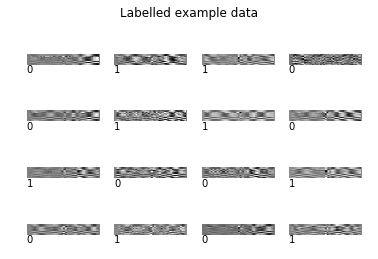

In [55]:
print(ecgData.shape)
visualiseData(np.reshape(ecgData, (-1,15,2000)), classData, 4, False)
#plt.savefig("./outData/figures/messy_mcg_example300buf.pdf")

In [56]:
if k == 1:
    visualiseData(np.reshape(unseenData, (-1,15,2000)), unseenClass, 2, False)

# Neural Network

In [57]:
healthEval = []
illEval = []
spec = []
sens = []
unseenSpec = []
unseenSens = []
unseenAvg = []
roc = []

In [68]:
if k != 1: # Perform a k fold cross validation
    for i in np.arange(0,k,1):
        sess = tf.InteractiveSession()
        tf.reset_default_graph()
        tflearn.initializations.normal()

        # Input layer:
        net = tflearn.layers.core.input_data(shape=[None, 15, 500, 1])

        # First layer:
        net = tflearn.layers.conv.conv_2d(net, 32, [15,3], activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_2d(net, 2)
        
        # Second layer (added)
        net = tflearn.layers.conv.conv_2d(net, 64, [15,3], activation="leaky_relu")
        net = tflearn.layers.conv.max_pool_2d(net, 2)

        # Fully connected layer 1:
        net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

        # Dropout layer:
        net = tflearn.layers.core.dropout(net, keep_prob=0.5)

        # Output layer:
        net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")

        net = tflearn.layers.estimator.regression(net, optimizer='adam', loss='categorical_crossentropy',\
                                 learning_rate=0.0001)

        model = tflearn.DNN(net, tensorboard_verbose=3)
        dummyData = np.reshape(np.concatenate(kfoldData[:i] + kfoldData[i+1:], axis=0), [-1, 15, 2000, 1])
        dummyLabels = np.reshape(np.concatenate(kfoldLabelsOH[:i] + kfoldLabelsOH[i+1:], axis=0), [-1, 2])
        model.fit(dummyData[:,:,::4], dummyLabels, n_epoch=10, show_metric=True)

        illTest = []
        healthTest = []
        for index, item in enumerate(kfoldLabels[i]):
            if item == 1:
                illTest.append(kfoldData[i][index])
            if item == 0:
                healthTest.append(kfoldData[i][index])

        healthLabel = np.tile([1,0], (len(healthTest), 1))
        illLabel = np.tile([0,1], (len(illTest), 1))

        sens.append(model.evaluate(np.array(healthTest)[:,:,::4], healthLabel))
        spec.append(model.evaluate(np.array(illTest)[:,:,::4], illLabel))
        
        # Get roc curve data
        predicted = np.array(model.predict(np.array(kfoldData[i])[:,:,::4]))
        fpr, tpr, th = roc_curve(kfoldLabels[i], predicted[:,1])
        roc.append([fpr, tpr])

if k == 1: # Only do one run
    sess = tf.InteractiveSession()
    tf.reset_default_graph()
    tflearn.initializations.normal()

    # Input layer:
    net = tflearn.layers.core.input_data(shape=[None, 15, 500, 1])

    # First layer:
    net = tflearn.layers.conv.conv_2d(net, 32, [15,3],  activation="leaky_relu")
    net1 = net
    net = tflearn.layers.conv.max_pool_2d(net, 2)

    # Second layer:
    net = tflearn.layers.conv.conv_2d(net, 64, [15,3], activation="leaky_relu")
    net3 = net
    net = tflearn.layers.conv.max_pool_2d(net, 2)
    
    # Fully connected layer
    net = tflearn.layers.core.fully_connected(net, 1024, regularizer="L2", weight_decay=0.001, activation="leaky_relu")

    # Dropout layer:
    net = tflearn.layers.core.dropout(net, keep_prob=0.5)

    # Output layer:
    net = tflearn.layers.core.fully_connected(net, 2, activation="softmax")
    
    net = tflearn.layers.estimator.regression(net, optimizer='adam', learning_rate=0.0001, loss='categorical_crossentropy')

    model = tflearn.DNN(net, tensorboard_verbose=3)
    model.fit(ecgData[:,:,::4], classDataOH, batch_size=32, n_epoch=10, show_metric=True)

Training Step: 49  | total loss: 0.54141 | time: 14.551s
| Adam | epoch: 010 | loss: 0.54141 - acc: 0.7386 -- iter: 256/267
Training Step: 50  | total loss: 0.54775 | time: 19.520s
| Adam | epoch: 010 | loss: 0.54775 - acc: 0.7356 -- iter: 267/267
--


In [69]:
if k != 1:
    print("Specificity:", spec, "\nAvg:", np.mean(spec), "\nSensitivity:", sens, "\nAvg:", np.mean(sens))

else:
    print(model.evaluate(unseenData[:,:,::4], unseenClassOH),"\n",\
    model.evaluate(np.array(iUnseen)[:,:,::4], unseenIL),"\n",\
    model.evaluate(np.array(hUnseen)[:,:,::4], unseenHL))

Specificity: [[0.23880596458911896], [0.5223880410194397], [0.23880596458911896], [1.0], [0.10447761416435242], [0.8507462739944458], [0.87096774578094482], [0.40298506617546082]] 
Avg: 0.528647083789 
Sensitivity: [[0.98507463932037354], [0.76119405031204224], [0.97014927864074707], [0.056338027119636536], [1.0], [0.53731346130371094], [0.54929578304290771], [0.9848484992980957]] 
Avg: 0.73052671738


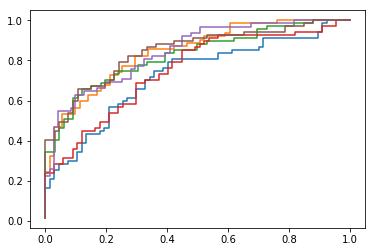

In [72]:
# Get ROC curves
if k == 1:
    predicted = np.array(model.predict(np.array(unseenData)[:,:,::4]))
    fpr, tpr, th = roc_curve(unseenClass, predicted[:,1])
    plt.plot(fpr,tpr)
    
if k != 1:
    for i in np.arange(k):
        plt.plot(roc[i][0], roc[i][1])

## What do the filters look like?

In [48]:
def display_convolutions(model, layer, padding=4, filename=''):
    """
    Taken from smistad @ https://github.com/tflearn/tflearn/issues/291.
    """
    if isinstance(layer, six.string_types):
        vars = tflearn.get_layer_variables_by_name(layer)
        variable = vars[0]
    else:
        variable = layer.W

    data = model.get_weights(variable)

    # N is the total number of convolutions
    N = data.shape[2] * data.shape[3]
    print(data.shape)

    # Ensure the resulting image is square
    filters_per_row = int(np.ceil(np.sqrt(N)))
    # Assume the filters are square
    filter_size = data.shape[0], data.shape[1]
    # Size of the result image including padding
    result_size = filters_per_row * (filter_size[0] + padding) - padding, \
                    filters_per_row * (filter_size[1] + padding) - padding
    # Initialize result image to all zeros
    result = np.zeros((result_size[0], result_size[1]))

    # Tile the filters into the result image
    filter_x = 0
    filter_y = 0
    for n in range(data.shape[3]):
        for c in range(data.shape[2]):
            if filter_x == filters_per_row:
                filter_y += 1
                filter_x = 0
            for i in range(filter_size[0]):
                for j in range(filter_size[1]):
                    result[filter_y * (filter_size[0] + padding) + i, filter_x * (filter_size[1] + padding) + j] = \
                        data[i, j, c, n]
            filter_x += 1

    # Normalize image to 0-1
    min = result.min()
    max = result.max()
    result = (result - min) / (max - min)

    # Plot figure
    plt.figure(figsize=(10, 20))
    plt.axis('off')
    plt.imshow(result.T, cmap='hot', interpolation='nearest')

    # Save plot if filename is set
    if filename != '':
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

    plt.show()

(15, 3, 1, 32)


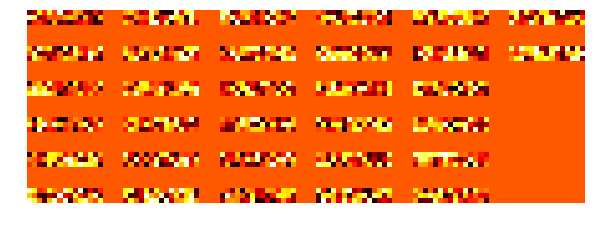

In [49]:
display_convolutions(model, net1, padding=4, filename='filters_2dConv.png')

(15, 3, 32, 64)


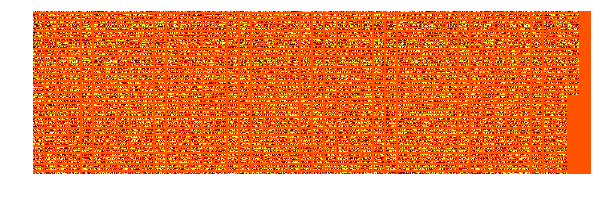

In [50]:
display_convolutions(model, net3, padding=2, filename='')